# **Project 4: Generate new photograph**

**Description:**

> Machine learning has covered almost all industries and it has helped humans
to mimic human-like behavior. Additionally, there are quite a few tasks where
ML algorithms are proven better than humans where humans have physical limi-
tations to achieve the task. One such interesting area is Image generation. A few
of the fields where image generation can be useful are redressing a person with a
given outfit or glasses, providing measurement of the cloth based on a photo of a
person, identifying the image of a person after 25 years, etc.


> The CIFAR-10 dataset (Canadian Institute for Advanced Research) is a collection
of images that are commonly used to train machine learning and computer vision
algorithms. It is one of the most widely used datasets for machine learning rese-
arch. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different
classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs,
frogs, horses, ships, and trucks. There are 6,000 images of each class.

> The scope of this project is to generate a new image that is not available in
real life, based on a model trained using the Generative Adversarial Model (GAN).

-------------------------

**Project Outcomes:**

> • Preprocess and clean the data.

> • Explore various options of GAN to find the most optimized model.

> • Generate a new image with a newly trained algorithm.

### **Imports:**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from keras.utils import plot_model


In [3]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### **Data Visualization**

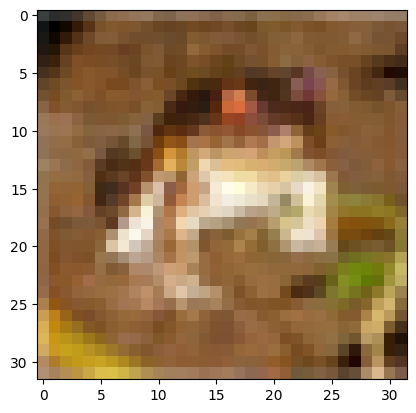

In [4]:
plt.imshow(x_train[0])

In [5]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

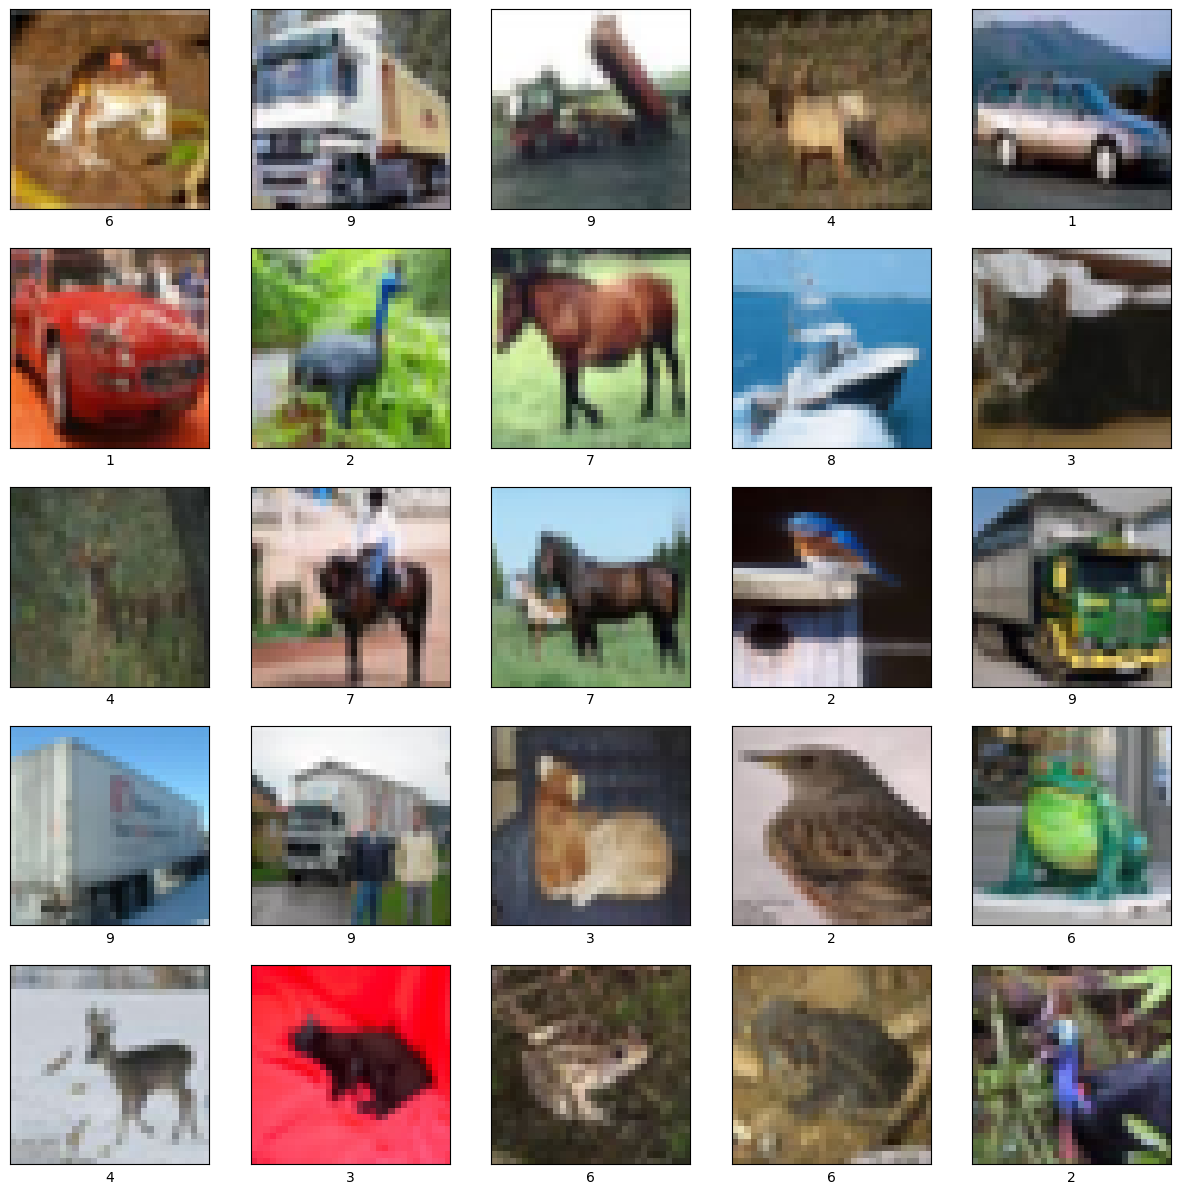

In [6]:
# Create a figure with a specified size to display multiple images.
plt.figure(figsize=(15,15))

# Loop through the first 25 images in the training dataset.
for i in range(25):
    # Arrange the images in a 5x5 grid.
    plt.subplot(5, 5, i + 1)
    # Remove x and y tick marks for a cleaner look.
    plt.xticks([])
    plt.yticks([])
    # Display each image.
    plt.imshow(x_train[i])
    # Label each image with its corresponding label from 'trainy'.
    plt.xlabel(y_train[i])

# Display the plotted figure with the images.
plt.show()

### **Define Discriminator, Generator, and combined GAN models**

In [7]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential

# Define the discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # Downsample
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # Downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    # Classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # Foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    # Upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

# Define the combined GAN model
def define_gan(generator, discriminator):
    # Make the discriminator not trainable
    discriminator.trainable = False
    # Connect them
    model = Sequential()
    # Add generator
    model.add(generator)
    # Add the discriminator
    model.add(discriminator)
    # Compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Size of the latent space
latent_dim = 100


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

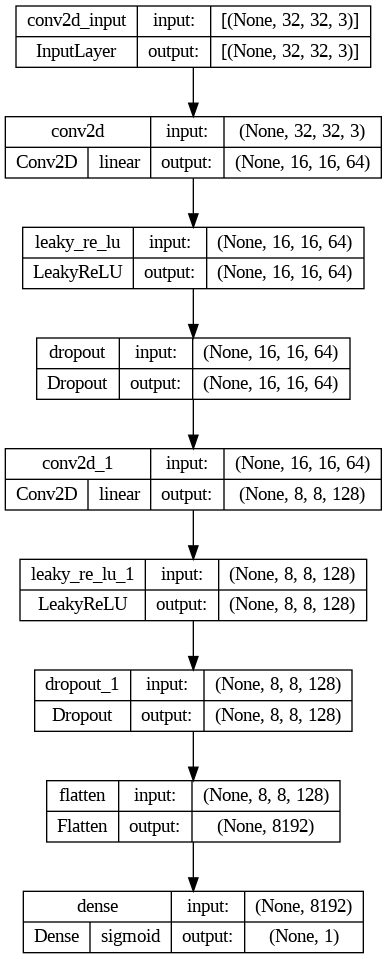

In [8]:
# Create the discriminator
discriminator = define_discriminator()
discriminator.summary()

# Visualize the discriminator model's architecture, including layer shapes, names, and activations.
plot_model(discriminator, show_shapes=True, show_layer_names=True, show_layer_activations=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

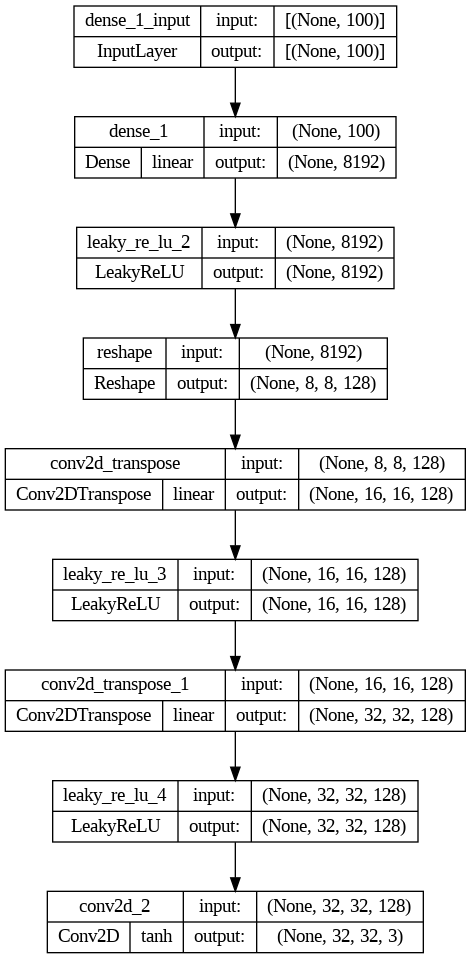

In [9]:
# Create the generator
generator = define_generator(latent_dim)
generator.summary()

# Visualize the structure of the generator model, displaying layer shapes, names, and activation functions.
plot_model(generator, show_shapes=True, show_layer_names=True, show_layer_activations=True)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1355395   
                                                                 
 sequential (Sequential)     (None, 1)                 83841     
                                                                 
Total params: 1439236 (5.49 MB)
Trainable params: 1355395 (5.17 MB)
Non-trainable params: 83841 (327.50 KB)
_________________________________________________________________


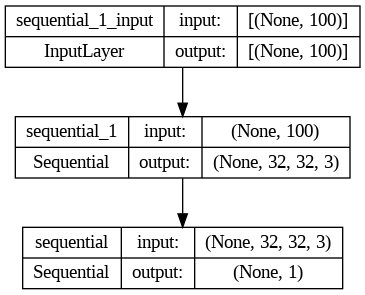

In [10]:
# Create the GAN
gan = define_gan(generator, discriminator)
gan.summary()

# Visualize the GAN model's structure, showing layer shapes, names, and activation functions.
plot_model(gan, show_shapes=True, show_layer_names=True, show_layer_activations=True)

### **Train GAN**

In [11]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model
from keras.models import load_model

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (_, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0

# Constants
batch_size = 1000
n_epochs = 5
half_batch = int(batch_size / 2)
latent_dim = 100

In [12]:
# Define the generator, discriminator, and GAN models here (use the functions defined previously)

# Define function to generate real samples
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y


In [13]:
# Define function to generate fake samples
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [14]:
# Define save_plot function here
def save_plot(examples, epoch, n=10):
    # Creates a grid plot for the generated images
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    # Construct the filename with the current epoch number.
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    # Save the plot to a file.
    plt.savefig(filename)
    # Close the plot to free up memory.
    plt.close()

In [15]:
# Define evaluate function here
def evaluate(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    # Evaluate the discriminator on real and fake samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)

    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose=0)

    print(f'>Accuracy real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')
    # Save generated images
    save_plot(X_fake, epoch)

    # Save the generator model
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    generator.save(filename)

In [ ]:
# Training loop
for i in range(n_epochs):
    for j in range(int(x_train.shape[0] / batch_size)):
        X_real, y_real = generate_real_samples(x_train, half_batch)
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
        d_loss, _ = discriminator.train_on_batch(X, y)

        X_gan = np.random.randn(latent_dim * batch_size)
        X_gan = X_gan.reshape(batch_size, latent_dim)
        y_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(X_gan, y_gan)

        #print(f'>{i+1}, {j+1}/{int(x_train.shape[0] / batch_size)}, d={d_loss:.3f}, g={g_loss:.3f}')
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, int(x_train.shape[0] / batch_size), d_loss, g_loss))


    if (i+1) % 1 == 0:
        evaluate(i, generator, discriminator, x_train, latent_dim)


16/16 [==============================] - 4s 230ms/step
>1, 1/50, d=0.725, g=0.770
16/16 [==============================] - 2s 152ms/step
>1, 2/50, d=0.717, g=0.748
16/16 [==============================] - 4s 232ms/step
>1, 3/50, d=0.720, g=0.701
16/16 [==============================] - 2s 153ms/step
>1, 4/50, d=0.715, g=0.699
16/16 [==============================] - 3s 188ms/step
>1, 5/50, d=0.706, g=0.715
16/16 [==============================] - 2s 155ms/step
>1, 6/50, d=0.699, g=0.788
16/16 [==============================] - 2s 154ms/step
>1, 7/50, d=0.681, g=0.886
16/16 [==============================] - 4s 218ms/step
>1, 8/50, d=0.672, g=0.865
16/16 [==============================] - 2s 150ms/step
>1, 9/50, d=0.676, g=0.882
16/16 [==============================] - 4s 236ms/step
>1, 10/50, d=0.690, g=0.772
16/16 [==============================] - 2s 154ms/step
>1, 11/50, d=0.712, g=0.730
16/16 [==============================] - 3s 165ms/step
>1, 12/50, d=0.723, g=0.705
16/16 [======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 4s 238ms/step
>2, 1/50, d=0.701, g=0.659
16/16 [==============================] - 2s 152ms/step
>2, 2/50, d=0.699, g=0.677
16/16 [==============================] - 3s 216ms/step
>2, 3/50, d=0.695, g=0.702
16/16 [==============================] - 2s 152ms/step
>2, 4/50, d=0.693, g=0.725
16/16 [==============================] - 2s 151ms/step
>2, 5/50, d=0.692, g=0.745
16/16 [==============================] - 4s 237ms/step
>2, 6/50, d=0.692, g=0.753
16/16 [==============================] - 2s 154ms/step
>2, 7/50, d=0.691, g=0.745
16/16 [==============================] - 2s 152ms/step
>2, 8/50, d=0.689, g=0.735
16/16 [==============================] - 3s 177ms/step
>2, 9/50, d=0.686, g=0.726
16/16 [==============================] - 2s 149ms/step
>2, 10/50, d=0.683, g=0.720
16/16 [==============================] - 4s 231ms/step
>2, 11/50, d=0.682, g=0.714
16/16 [==============================] - 2s 152ms/step
>2, 12/50, d=0.685, g=0.720
16/16 [======

>Accuracy real: 18%, fake: 100%


16/16 [==============================] - 4s 238ms/step
>3, 1/50, d=0.689, g=0.782
16/16 [==============================] - 2s 155ms/step
>3, 2/50, d=0.696, g=0.759
16/16 [==============================] - 3s 220ms/step
>3, 3/50, d=0.704, g=0.738
16/16 [==============================] - 2s 152ms/step
>3, 4/50, d=0.709, g=0.726
16/16 [==============================] - 3s 155ms/step
>3, 5/50, d=0.711, g=0.725
16/16 [==============================] - 3s 179ms/step
>3, 6/50, d=0.712, g=0.704
16/16 [==============================] - 2s 154ms/step
>3, 7/50, d=0.708, g=0.674
16/16 [==============================] - 4s 236ms/step
>3, 8/50, d=0.699, g=0.659
16/16 [==============================] - 3s 156ms/step
>3, 9/50, d=0.693, g=0.671
16/16 [==============================] - 4s 234ms/step
>3, 10/50, d=0.692, g=0.708
16/16 [==============================] - 2s 155ms/step
>3, 11/50, d=0.686, g=0.729
16/16 [==============================] - 3s 217ms/step
>3, 12/50, d=0.686, g=0.770
16/16 [======

16/16 [==============================] - 3s 165ms/step
>4, 1/50, d=0.691, g=0.658
16/16 [==============================] - 3s 163ms/step
>4, 2/50, d=0.692, g=0.657
16/16 [==============================] - 2s 152ms/step
>4, 3/50, d=0.694, g=0.664
16/16 [==============================] - 3s 188ms/step
>4, 4/50, d=0.695, g=0.682
16/16 [==============================] - 2s 154ms/step
>4, 5/50, d=0.696, g=0.703
16/16 [==============================] - 4s 230ms/step
>4, 6/50, d=0.698, g=0.714
16/16 [==============================] - 2s 153ms/step
>4, 7/50, d=0.700, g=0.716
16/16 [==============================] - 4s 235ms/step
>4, 8/50, d=0.700, g=0.712
16/16 [==============================] - 2s 154ms/step
>4, 9/50, d=0.700, g=0.707
16/16 [==============================] - 2s 153ms/step
>4, 10/50, d=0.697, g=0.705
16/16 [==============================] - 4s 234ms/step
>4, 11/50, d=0.689, g=0.712
16/16 [==============================] - 2s 152ms/step
>4, 12/50, d=0.684, g=0.714
16/16 [======

>Accuracy real: 100%, fake: 0%


16/16 [==============================] - 3s 194ms/step
>5, 1/50, d=0.699, g=0.691
16/16 [==============================] - 2s 150ms/step
>5, 2/50, d=0.696, g=0.724
16/16 [==============================] - 2s 146ms/step
>5, 3/50, d=0.693, g=0.748
16/16 [==============================] - 3s 206ms/step
>5, 4/50, d=0.691, g=0.762
16/16 [==============================] - 2s 151ms/step
>5, 5/50, d=0.691, g=0.762
16/16 [==============================] - 4s 231ms/step
>5, 6/50, d=0.691, g=0.748
16/16 [==============================] - 2s 151ms/step
>5, 7/50, d=0.692, g=0.718
16/16 [==============================] - 3s 173ms/step
>5, 8/50, d=0.693, g=0.689
16/16 [==============================] - 2s 150ms/step
>5, 9/50, d=0.693, g=0.681
16/16 [==============================] - 2s 152ms/step
>5, 10/50, d=0.691, g=0.686
16/16 [==============================] - 3s 212ms/step
>5, 11/50, d=0.689, g=0.703
16/16 [==============================] - 2s 151ms/step
>5, 12/50, d=0.685, g=0.737
16/16 [======

### **Evaluate Model: (Accuracy)**

In [95]:
def evaluate_on_test_set(generator, discriminator, test_dataset, latent_dim, n_samples=100):
    # Generate a batch of real samples from the test set
    X_real, y_real = generate_real_samples(test_dataset, n_samples)
    # Evaluate the discriminator on real samples
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)

    # Generate a batch of fake samples
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    # Evaluate the discriminator on fake samples
    _, acc_fake = discriminator.evaluate(X_fake, y_fake, verbose=0)

    # Print the accuracy
    print(f'Test Set Accuracy - Real: {acc_real*100:.0f}%, Fake: {acc_fake*100:.0f}%')

# Call this function to evaluate the model on the test set
evaluate_on_test_set(generator, discriminator, x_test, latent_dim)



4/4 [==============================] - 1s 115ms/step
Test Set Accuracy - Real: 74%, Fake: 91%


### **Generate a New Image**

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the final trained generator model
# Replace 'final_model.h5' with the filename of your saved model
model = load_model('/content/generator_model_030.h5')

# Generate random input from the latent space
random_input = np.random.randn(100)  # 100 is the size of the latent dimension
random_input = random_input.reshape(1, 100)

# Use the generator to create an image
generated_image = model.predict(random_input)

# Display the generated image
plt.imshow(generated_image[0, :, :, :])
plt.axis('off')
plt.show()

